In [1]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [2]:
net = nx.read_graphml("sheep_ml.graphml")

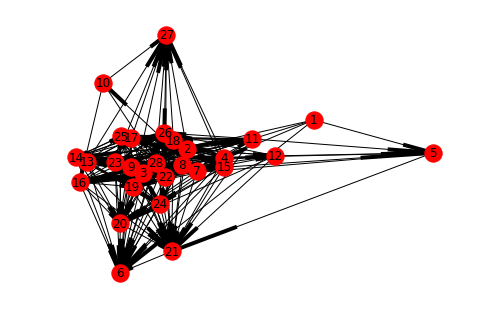

In [3]:
nx.draw_spring(net,with_labels=True)

In [4]:
net.adj

AdjacencyView({'1': {'2': {'weight': 1}, '3': {'weight': 1}, '4': {'weight': 1}, '5': {'weight': 1}, '6': {'weight': 1}}, '2': {'4': {'weight': 1}, '7': {'weight': 1}, '8': {'weight': 5}, '9': {'weight': 3}, '12': {'weight': 1}, '13': {'weight': 2}, '15': {'weight': 1}, '21': {'weight': 4}, '22': {'weight': 1}, '23': {'weight': 2}, '24': {'weight': 3}, '26': {'weight': 5}, '27': {'weight': 2}, '28': {'weight': 4}}, '3': {'2': {'weight': 1}, '4': {'weight': 1}, '5': {'weight': 1}, '6': {'weight': 5}, '8': {'weight': 1}, '9': {'weight': 7}, '14': {'weight': 7}, '15': {'weight': 5}, '16': {'weight': 2}, '18': {'weight': 3}, '19': {'weight': 5}, '20': {'weight': 6}, '21': {'weight': 1}, '23': {'weight': 8}, '24': {'weight': 2}, '25': {'weight': 3}, '26': {'weight': 4}, '28': {'weight': 1}}, '4': {'2': {'weight': 1}, '3': {'weight': 2}, '5': {'weight': 1}, '6': {'weight': 1}, '11': {'weight': 1}, '12': {'weight': 1}, '15': {'weight': 2}, '16': {'weight': 1}, '18': {'weight': 2}, '19': {'wei

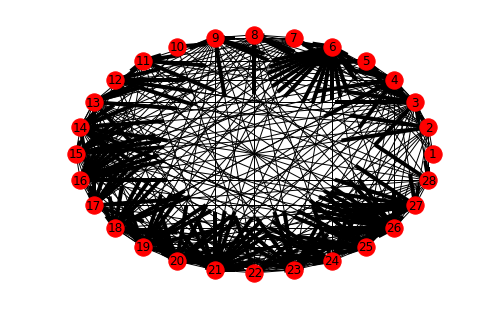

In [5]:
nx.draw_circular(net, with_labels=True)

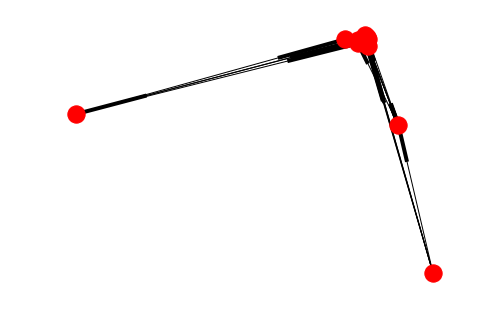

In [6]:
nx.draw_spectral(net)

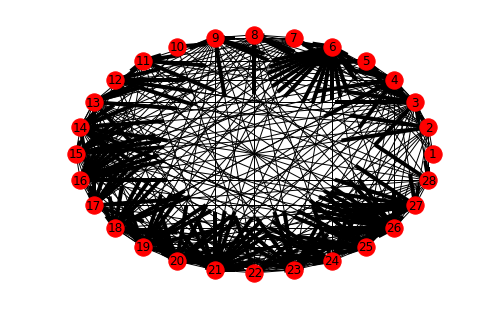

In [7]:
nx.draw_shell(net, with_labels=True)

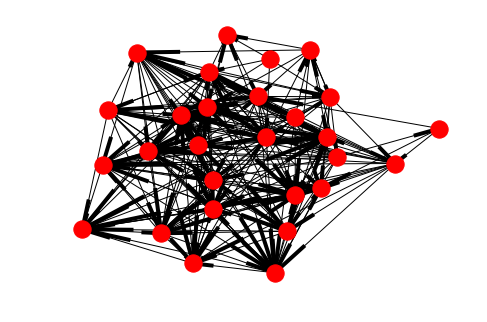

In [8]:
nx.draw_kamada_kawai(net)

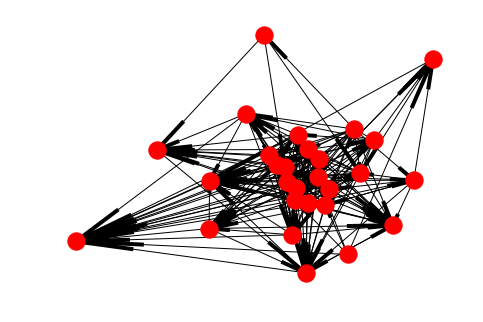

In [9]:
nx.draw(net)

In [10]:
import json
from networkx.readwrite import json_graph

In [11]:
d = json_graph.node_link_data(net)
json.dump(d, open("force.json","w"), indent=4)

In [12]:
from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4


In [13]:
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Sheep Interactive Network Graph"

plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())

graph_renderer = from_networkx(net, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

In [14]:
# Convert the node IDs from strings to integers for use in D3 script
net_int = nx.convert_node_labels_to_integers(net, first_label=0, ordering='default', label_attribute=None)

In [15]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(net_int)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

In [53]:
%%html
<div id="sheep-viz"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [54]:
%%javascript

require.config({paths: {d3: "javascript/d3.v4.min"}});
require(["d3"], function(d3) {
    
    // Size of the canvas
    var width = 800,
        height = 600;

    // We create a color scale.
    var color = d3.scale.category10();

    // Create a force-directed dynamic graph layout.
    var force = d3.layout.force()
        .charge(-300)  // -120
        .linkDistance(width/4)
        .size([width, height]);

    // In the <div> element, we create a <svg> graphic
    // that will contain our interactive visualization.
    var svg = d3.select("#sheep-viz").select("svg")
    if (svg.empty()) {
        svg = d3.select("#sheep-viz").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }
       

    // We load the JSON file.
    d3.json("graph.json", function(error, graph) {
        // In this block, the file has been loaded
        // and the 'graph' object contains our graph.
        
        // We load the nodes and links in the force-directed
        // graph.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a <line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");
        
        // We create a <circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", function(d) {
                return d.age*2.0;
            })
            .style("fill", function(d) {
                return color(0);
            })
            .call(force.drag);

        // The name of each node is the node number.
        node.append("title")
            .text(function(d) { return "Sheep ID = " + d.id; });

        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});

<IPython.core.display.Javascript object>